In [16]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import lightkurve as lk
from scipy.optimize import curve_fit
import pandas as pd

In [17]:
# Specify the Eclipsing CVs: 
TIC = 'TIC 337646214'

data_all = lk.search_lightcurve(TIC, author = 'SPOC')

data_all

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 44,2021,SPOC,20,337646214,0.0
1,TESS Sector 44,2021,SPOC,120,337646214,0.0
2,TESS Sector 45,2021,SPOC,20,337646214,0.0
3,TESS Sector 45,2021,SPOC,120,337646214,0.0
4,TESS Sector 46,2021,SPOC,20,337646214,0.0
5,TESS Sector 46,2021,SPOC,120,337646214,0.0
6,TESS Sector 72,2023,SPOC,20,337646214,0.0
7,TESS Sector 72,2023,SPOC,120,337646214,0.0


In [18]:
data = data_all[0]

lc = data.download_all().stitch()

In [19]:
# Define initial guesses for A, mu, and sigma
A_guess = 0.675
mu_guess = 2500.47
sigma_guess = 0.1

# Get the period in julian days
period_julian_days = 0.3007600205719854

# Period of the eclipsing binar
P = 0.3007600205719854

In [20]:
from decimal import Decimal, getcontext
import numpy as np
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian_function(x, A, mu, sigma):
    return -(A * np.exp(-((x - mu)**2) / (2 * sigma**2))-1)

getcontext().prec = 30

def get_O_values(start_index, end_index, mu_fit):
    Times = lc.time[start_index:end_index]
    t = Time(Times)
    x = np.array(t.btjd)
    y = np.array(lc.flux[start_index:end_index])
    
    # Remove invalid values (infs and NaNs) from y and x arrays
    mask_valid = ~np.isnan(y) & ~np.isinf(y)
    x, y = x[mask_valid], y[mask_valid]
    
    if len(x) > 3:

        try:
            params, covariance = curve_fit(gaussian_function, x, y, p0=[A_guess, mu_fit, sigma_guess])
            mu_fit = params[1]  # Update mu_fit with the adjusted value
            
            # Get fitted values for A, μ and σ
            A_fit, mu_fit, sigma_fit = params
            
            # Get the diagonals of the covariance matrix as the variance of μ
            var_mu_fit = np.diag(covariance)[1] 
            
            # Check mu variances and calculate errors
            var_mu_fit_decimal = Decimal(var_mu_fit)
            error_mu_fit = var_mu_fit_decimal.sqrt() 
            error_mu_fit = float(error_mu_fit)
        
            #Add to the lists
            mu_fit_values.append(mu_fit)
            error_mu_fit_values.append(error_mu_fit)
            
        except RuntimeError:
            print("Curve fitting failed to converge")

    else:
        mu_fit = 2514.5  # Valor predeterminado si x es demasiado pequeño

    return mu_fit

# Create the initial_guess list
initial_guess = [A_guess, mu_guess, sigma_guess]

# Initialize mu_fit with the initial guess value for mu
mu_fit = initial_guess[1]

# Initialize lists for mu_fit and error_mu_fit values
mu_fit_values = []
error_mu_fit_values = []

# Iterate through the light curve and process chunks of data with the given period
start_index = 0
i=1
while start_index < len(lc) and i < 59:
    end_time = lc.time[start_index] + period_julian_days
    end_index = np.searchsorted(lc.time, end_time, side='right')
    
    # Call process_chunk with the updated mu_fit value
    mu_fit = get_O_values(start_index, end_index, mu_fit)
    mu_fit = mu_fit + period_julian_days
    
    # Update the start_index for the next iteration
    start_index = end_index
    i=i+1 

#Print O values data table 

df = pd.DataFrame({'O Values': mu_fit_values, 'O Values Errors': error_mu_fit_values})
print(df)


       O Values  O Values Errors
0   2500.471836         0.000253
1   2500.772239         0.000269
2   2501.072328         0.000241
3   2501.373399         0.000254
4   2501.673553         0.000206
5   2501.973910         0.000212
6   2502.274767         0.000213
7   2502.574901         0.000240
8   2502.874677         0.000188
9   2503.176303         0.000178
10  2503.476299         0.000214
11  2503.776736         0.000217
12  2504.077366         0.000249
13  2504.377904         0.000254
14  2504.678386         0.000257
15  2504.978747         0.000248
16  2505.279629         0.000281
17  2505.580090         0.000276
18  2505.880466         0.000257
19  2506.180720         0.000212
20  2506.481619         0.000208
21  2506.782481         0.000190
22  2507.082460         0.000172
23  2507.382966         0.000212
24  2507.683301         0.000235
25  2507.984355         0.000239
26  2508.284535         0.000231
27  2508.584154         0.000206
28  2508.884778         0.000215
29  2509.1

In [21]:
def get_OC_values(mu_fit_values, P):
    
    # Given observed times (O) of minima for an eclipsing binary
    observed_times = np.array(mu_fit_values)

    T0 = mu_fit_values [0]  # The first mu_fit is T0

    # Calculate the epoch (E) for each mu_fit (O) value
    epochs = np.round((mu_fit_values - T0) / P)

    # Calculate the calculated times (C) using the linear ephemeris model
    calculated_times = T0 + P * epochs

    # Calculate the O-C values
    oc_values = observed_times - calculated_times
    
    return epochs, calculated_times, oc_values

# Create a DataFrame to store the results
epochs, calculated_times, oc_values = get_OC_values(mu_fit_values, P)
oc_data_table = pd.DataFrame({'mu_fit': mu_fit_values,'Epochs': epochs,'Calculated Times': calculated_times,'O-C Values': oc_values})
print(oc_data_table)

         mu_fit  Epochs  Calculated Times  O-C Values
0   2500.471836     0.0       2500.471836    0.000000
1   2500.772239     1.0       2500.772596   -0.000357
2   2501.072328     2.0       2501.073356   -0.001028
3   2501.373399     3.0       2501.374116   -0.000717
4   2501.673553     4.0       2501.674876   -0.001323
5   2501.973910     5.0       2501.975636   -0.001726
6   2502.274767     6.0       2502.276396   -0.001629
7   2502.574901     7.0       2502.577156   -0.002255
8   2502.874677     8.0       2502.877916   -0.003239
9   2503.176303     9.0       2503.178676   -0.002373
10  2503.476299    10.0       2503.479436   -0.003137
11  2503.776736    11.0       2503.780196   -0.003460
12  2504.077366    12.0       2504.080956   -0.003590
13  2504.377904    13.0       2504.381716   -0.003812
14  2504.678386    14.0       2504.682476   -0.004090
15  2504.978747    15.0       2504.983236   -0.004489
16  2505.279629    16.0       2505.283996   -0.004367
17  2505.580090    17.0     

In [22]:
# Fit a linear model to the O-C values vs. epochs
def linear_model(x, a):
    return a * x

params, covariance = curve_fit(linear_model, calculated_times, oc_values)


# The slope of the linear fit represents P-dot (dP/dt)
p_dot = params[0]

# Print the calculated P-dot value
print(f"Calculated P-dot: {p_dot}")

Calculated P-dot: -2.112468266226397e-06


Best fit equation:
y = -0.0007x + 1.7293


<IPython.core.display.Javascript object>


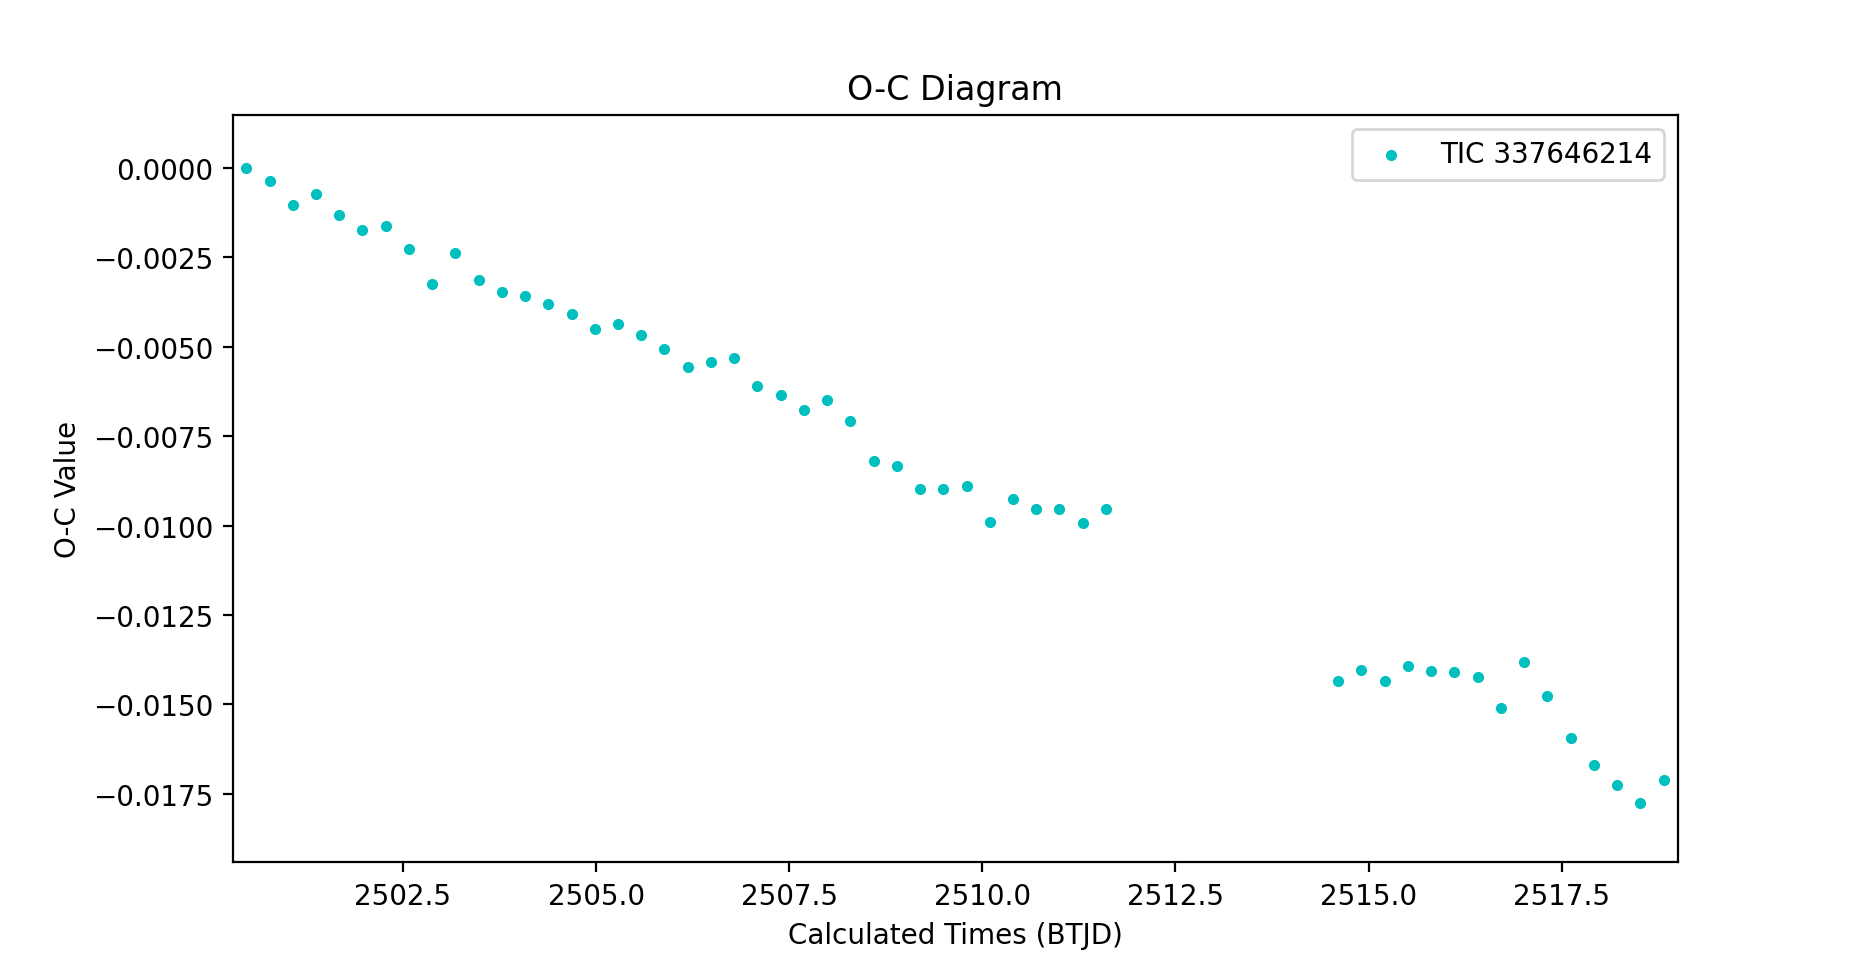

In [27]:
def graph():
    import numpy as np
    import matplotlib.pyplot as plt
    from numpy.polynomial.polynomial import Polynomial

    #data points
    x = np.array(calculated_times)
    y = np.array(oc_values)

    # Fit a polynomial curve
    degree = 1
    coefs = np.polyfit(x, y, degree)

    # Create a polynomial
    p = Polynomial(coefs[::-1])

    # Print the curve equation
    equation = "y = {:.4f}x + {:.4f}".format(coefs[0], coefs[1])
    print("Best fit equation:")
    print(equation)

    # Graficar
    xp = np.linspace(min(calculated_times), max(calculated_times), 100)
    plt.ylim([-0.05, 0.05])
    plt.scatter(x, y,label='TIC 337646214', marker='.', color='c',)
    #plt.plot(xp, p(xp), '-', label='Fitted curve', color='black')
    plt.xlabel('Calculated Times (BTJD)')
    plt.ylabel('O-C Value')
    plt.title('O-C Diagram')
    plt.legend()
    plt.grid(False)
    plt.show()

graph()
